## MACS 40300: Problem Set #2 
Jesús Pacheco Vera


### 1. Health claim amounts and the GB family of distributions

In [1]:
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt


In [2]:
#Import the txt file
claims= np.loadtxt('/Users/jesuspacheco/Github/StructEst_W20/ProblemSets/PS2/clms2.txt')


In [3]:
#Import the txt file
url_claims = ('https://raw.githubusercontent.com/jesuspachecov/StructEst_W20/' +
       'master/ProblemSets/PS2/clms.txt')
response1 = requests.get(url_claims,allow_redirects=True)

open('clms.txt', 'wb').write(response1.content)
claims = np.loadtxt("clms.txt")
claims

array([361.65, 123.04, 541.77, ...,  97.43, 186.88, 119.19])

#### Part a)

In [4]:
print('Mean:' , np.mean(claims))
print('Median:' , np.median(claims))
print('Maximum:' , np.max(claims))
print('Minimum:' , np.min(claims))
print('Standard deviation:' , np.std(claims))

Mean: 720.2779753272437
Median: 172.21
Maximum: 227967.25
Minimum: 0.01
Standard deviation: 3972.663756393663


Text(0.5, 1.0, 'Histogram of monthly claims')

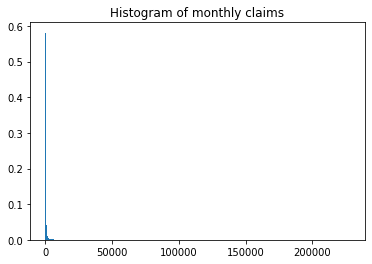

In [5]:
#Compute weights so we can have 
weights = (1 / claims.shape[0]) * np.ones_like(claims)
plt.hist(claims, 1000, weights=weights)
plt.title('Histogram of monthly claims')

Text(0.5, 1.0, 'Histogram of monthly claims (less or equal to 800 usd)')

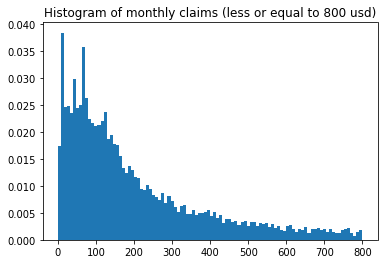

In [6]:
plt.hist(claims[claims<=800], 100, weights=weights[claims<=800])
plt.title('Histogram of monthly claims (less or equal to 800 usd)')

Since we have some few enormous outliers in the data, the first histogram is not very informative of the distribution. The second one is much more informative of the part of the distribution that displays the biggest part of the data. 

#### Part b) 

In [7]:
import math
def gamma_pdf(xvals, alpha, beta):
    pdf_vals = (1/(beta**alpha*math.gamma(alpha))) * xvals**(alpha-1) * np.exp(-xvals/beta)
    return pdf_vals

In [13]:
#The function of the log likelihood
def log_lik_gamma(xvals, alpha, beta):
    pdf_vals = gamma_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_vals = ln_pdf_vals.sum()
    return log_lik_vals

In [16]:
#Critieron function
def crit(params):
    alpha, beta = params
    log_lik_val = log_lik_gamma(claims, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [17]:
#Minimization function
import scipy.optimize as opt

beta_init = np.std(claims)**2 / np.mean(claims)
alpha_init = np.mean(claims)/beta_init
params_init=np.array([alpha_init, beta_init])

results = opt.minimize(crit, params_init)


#alpha_MLE, beta_MLE = results.x
#print('alpha_MLE', alpha_MLE, ' beta_MLE', beta_MLE)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


OverflowError: math range error

In [235]:
gamma_pdf(claims, alpha_init, beta_init)

array([7.95516164e-05, 2.28154040e-04, 5.33731030e-05, ...,
       2.86257990e-04, 1.51849462e-04, 2.35319067e-04])

In [243]:
np.exp(.35)

1.4190675485932571

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


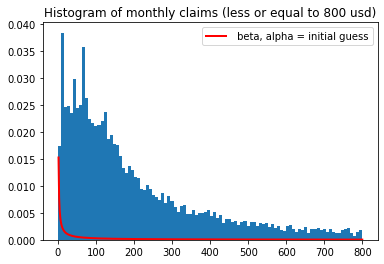

In [163]:
#The two plots together: 
plt.hist(claims[claims<=800], 100, weights=weights[claims<=800])
plt.title('Histogram of monthly claims (less or equal to 800 usd)')


plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_init, beta_init),
         linewidth=2, color='r', label=' beta, alpha = initial guess')
plt.legend(loc='upper right')


## 2. MLE estimation of simple macroeconomic model

In [223]:
#Read the MacroSeries.txt file
url_macro = ('https://raw.githubusercontent.com/jesuspachecov/StructEst_W20/' +
       'master/ProblemSets/PS2/MacroSeries.txt')
response = requests.get(url_macro,allow_redirects=True)

open('MacroSeries.txt', 'wb').write(response.content)
macroseries = np.loadtxt("MacroSeries.txt",
   dtype={'names': ('ct', 'kt', 'wt', 'rt'),
          'formats': (np.float, np.float, np.float, np.float)},
   delimiter=',', skiprows=0)
macroseries[1:10,]

array([(11694867.84030517, 7595071.76117567, 11610789.70793735, 1.10700906),
       ( 9292394.2429819 , 8323735.10441439,  9225588.25903715, 0.80259623),
       ( 7913164.54481106, 6613792.41053042,  7856274.28276346, 0.86017611),
       ( 8140994.1833072 , 5632135.94271214,  8082465.98137312, 1.03918305),
       ( 8274413.56372333, 5794291.99147403,  8214926.16733915, 1.02665514),
       ( 8625915.78131906, 5889252.24203382,  8563901.32345952, 1.05301073),
       ( 9012820.39756551, 6139431.32809391,  8948024.35910304, 1.05540782),
       ( 8788319.89128249, 6414807.80778456,  8725137.85851394, 0.98494039),
       ( 9720971.68924274, 6255021.24408637,  9651084.52543784, 1.11729699)],
      dtype=[('ct', '<f8'), ('kt', '<f8'), ('wt', '<f8'), ('rt', '<f8')])